<center> DL 기초 과제 제출_18기_수학과_신혜연 </center>

# 과제1: tensorflow를 이용한 NN 밑바닥부터 구현
input feature가 100개이고,  
hidden layer가 2개이고 neuron이 각각 50,10개이고,  
output이 5개인 NN를 구현해 보자  
* hidden layer는 relu를 activation function으로, output layer는 softmax를 activation function으로 사용

In [55]:
import tensorflow as tf
import numpy as np

In [56]:
n_x = 100
n_h1 = 50
n_h2 = 10
n_y = 5

In [57]:
# Simulate train set
m = 500

x_train=np.random.randn(m,n_x).astype(np.float32)
y_train=np.zeros((m,n_y)).astype(np.float32)
y_train[np.arange(m),np.random.randint(n_y,size=m)]=1

print(x_train)
print(y_train)

[[ 0.28218368  0.81470215 -1.8495196  ... -0.06682612  2.0496588
   1.1288776 ]
 [ 0.08744194 -0.9507087   0.85252374 ...  0.7319052   1.6886861
   1.7216228 ]
 [-0.69688684 -1.4522536  -0.9981475  ...  0.87236255 -0.0885678
  -0.18371195]
 ...
 [-1.8571856   0.8513595  -1.984289   ... -0.688826   -0.30422145
   0.43359625]
 [-0.1465678  -0.25818855 -0.8820431  ... -0.70325     1.4938787
   0.05920051]
 [ 1.0355052   1.3599312  -1.8821713  ... -1.8519206   0.86525637
  -0.9742082 ]]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


* Initialization of weights

In [58]:
w1=tf.Variable(1e-3*np.random.randn(n_x,n_h1).astype(np.float32),name="w1")
## 코드를 작성해 보세요 ##
w2=tf.Variable(1e-3*np.random.randn(n_h1,n_h2).astype(np.float32),name="w2")
w3=tf.Variable(1e-3*np.random.randn(n_h2,n_y).astype(np.float32),name="w3")

* forward propagation을 통해 prediction 값을 구하고, loss를 구하는 function을 만들어 봅시다

In [59]:
def forward(x):
    z1=tf.matmul(x,w1)
    a1=tf.nn.relu(z1)
    ## 코드를 작성해 보세요 ##
    z2=tf.matmul(a1,w2)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(a2,w3)
    predictions = tf.nn.softmax(z3)
    
    return predictions

def loss_fn(predictions, y):
    loss= -tf.reduce_sum(y*tf.math.log(predictions))
    return loss    

* backpropagation & update parameters

In [60]:
learning_rate=1e-2
optimizer=tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward(x)
        loss = loss_fn(predictions, y)
    ## 코드를 작성해 보세요 ## (hint: tape.gradient를 구글링 해보세요)
    gradient = tape.gradient(loss, [w1,w2,w3])
    # optimizer와 위에서 구한 경사도를 이용해 가중치들을 업데이트 합니다.
    optimizer.apply_gradients(zip(gradient, [w1, w2, w3]))
    return loss, w1, w2


* 간단하게 train loop를 작성해 loss가 줄어나가는지 확인해 봅시다.

In [61]:
loss_list = []

for step in range(10): 
    loss, w1, w2 = train_step(x_train, y_train)
    loss_list.append(loss.numpy())
    
print(loss_list)

[804.71875, 804.7199, 804.5861, 804.0121, 802.4454, 799.1798, 793.4011, 784.539, 772.8394, 759.4754]


LOSS가 줄어드는 것을 확인할 수 있다.


# 과제2: MNIST 데이터를 나만의 NN model로 95 % 이상의 성능으로 training 시켜보자!


## Loading MNIST training data

In [62]:
from tensorflow import keras

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling(image data는 min-max scaling 주로 사용)
x_train = x_train/255.0
x_test = x_test/255.0

## Training Data
28 * 28 pixel 값을 가진 총 60000개의 이미지 데이터

In [63]:
x_train.shape 

(60000, 28, 28)

Neural network 모델에 맞게 이미지 데이터를 벡터 형태로 데이터를 reshape 합니다.  
(Model을 만들 때 *keras.layers.Flatten(input_shape=(28, 28)) 이용해도 됨)

In [64]:
x_train, x_test = x_train.reshape((-1, 28*28)), x_test.reshape((-1, 28*28))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

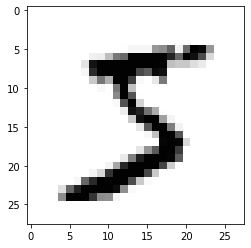

In [65]:
plt.imshow(x_train[0].reshape(28, 28)).set_cmap('Greys')

## Training Labels
이미지 데이터가 나타내는 숫자값을 label로 가지고 있고, 0부터 9까지의 값을 나타냄  
마찬가지로, 60000개의 label이 존재

In [66]:
y_train.shape

(60000,)

In [67]:
# show MNIST label for above data
y_train[0]

5

## 나만의 모델을 tensorflow keras API 를 이용해 만들어 봅시다~

* parameters for model

In [68]:
activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

#### My Own Model 

In [69]:
#### 자유롭게 Model을 만들고 compile 해봅시다 ####
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_dim=784, activation="relu", kernel_initializer=initializer_list[0]),
    tf.keras.layers.Dropout(0.6), 
    tf.keras.layers.Dense(256, input_dim=512, activation="relu", kernel_initializer=initializer_list[0]),
    tf.keras.layers.Dropout(0.6), 
    tf.keras.layers.Dense(128, input_dim=256, activation="relu", kernel_initializer=initializer_list[0]),
    tf.keras.layers.Dropout(0.6), 
    tf.keras.layers.Dense(64, input_dim=128, activation="relu", kernel_initializer=initializer_list[0]),
    tf.keras.layers.Dropout(0.6), 
    tf.keras.layers.Dense(10, input_dim=64, activation="softmax", kernel_initializer=initializer_list[0])
])

model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = "adam", 
              metrics = ['accuracy'])

내가 만든 모델을 확인해 봅시다.

In [70]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)              

model을 자유롭게 train 해봅시다.  

In [71]:
model.fit(x_train, y_train, epochs=8)

Epoch 1/8
1875/1875 [==============================] - 13s 7ms/step - loss: 1.2603 - accuracy: 0.5540
Epoch 2/8
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4119 - accuracy: 0.8955
Epoch 3/8
1875/1875 [==============================] - 12s 7ms/step - loss: 0.3305 - accuracy: 0.9196
Epoch 4/8
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2996 - accuracy: 0.9303
Epoch 5/8
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2713 - accuracy: 0.9350
Epoch 6/8
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2680 - accuracy: 0.9370
Epoch 7/8
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2435 - accuracy: 0.9435
Epoch 8/8
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2279 - accuracy: 0.9450


95%이상의 성능을 가진 모델을 만들면 완성!

In [72]:
test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)

print('\nAccuracy:', test_acc)

313/313 - 1s - loss: 0.1326 - accuracy: 0.9712

Accuracy: 0.9711999893188477


95% 이상의 성능을 가진 모델을 만들었다!